In [2]:
import jax.numpy as np
import matplotlib.pyplot as plt
import dLux as dl
import dLux.utils as dlu
import jax.random as jr
import dLuxToliman as dlT
import optax
import zodiax as zdx
import jax
from tqdm.notebook import tqdm
import pickle

In [3]:
with open('singlesource_results.pkl', 'rb') as f:
    data = pickle.load(f)

square_pos_errors = data['square_pos_errors']
square_flux_errors = data['square_flux_errors']
square_pos_errors_tol = data['square_pos_errors_tol']
square_flux_errors_tol = data['square_flux_errors_tol']

In [18]:
print(np.array(square_pos_errors)[:,4]**0.5)

[0.00832456 0.01767233 0.01003055 0.01222404 0.04094982 0.03281476
 0.09154146 0.03637932 0.03853023 0.0061702 ]


In [38]:
n_trials = 10

# this is so innefficent but I can't be bothered to think right now
mse_pos = []
mse_flux = []
mse_pos_tol = []
mse_flux_tol = []

# variance of square errors
vse_pos = []
vse_flux = []
vse_pos_tol = []
vse_flux_tol = []

for i in np.arange(6):
    mse_pos_i = np.mean(np.array(square_pos_errors)[:,i])
    mse_pos.append(mse_pos_i)
    vse_pos_i = np.var(np.array(square_pos_errors)[:,i])
    vse_pos.append(vse_pos_i)

    mse_flux_i = np.mean(np.array(square_flux_errors)[:,i])
    mse_flux.append(mse_flux_i)
    vse_flux_i = np.var(np.array(square_flux_errors)[:,i])
    vse_flux.append(vse_flux_i)

    mse_pos_tol_i = np.mean(np.array(square_pos_errors_tol)[:,i])
    mse_pos_tol.append(mse_pos_tol_i)
    vse_pos_tol_i = np.var(np.array(square_pos_errors_tol)[:,i])
    vse_pos_tol.append(vse_pos_tol_i)

    mse_flux_tol_i = np.mean(np.array(square_flux_errors_tol)[:,i])
    mse_flux_tol.append(mse_flux_tol_i)
    vse_flux_tol_i = np.var(np.array(square_flux_errors_tol)[:,i])
    vse_flux_tol.append(vse_flux_tol_i)

mse_pos = np.array(mse_pos)
mse_flux = np.array(mse_flux)
mse_pos_tol = np.array(mse_pos_tol)
mse_flux_tol = np.array(mse_flux_tol)

vse_pos = np.array(vse_pos)
vse_flux = np.array(vse_flux)
vse_pos_tol = np.array(vse_pos_tol)
vse_flux_tol = np.array(vse_flux_tol)

# variance of the mean square errors
vmse_pos = vse_pos/n_trials
vmse_flux = vse_flux/n_trials
vmse_pos_tol = vse_pos_tol/n_trials
vmse_flux_tol = vse_flux_tol/n_trials

# root mean square errors
rmse_pos = mse_pos**0.5
rmse_flux = mse_flux**0.5
rmse_pos_tol = mse_pos_tol**0.5
rmse_flux_tol = mse_flux_tol**0.5

# variance of the root mean square errors: 'delta method'
vrmse_pos = (1 / (2 * rmse_pos))**2 * vmse_pos
vrmse_flux = (1 / (2 * rmse_flux))**2 * vmse_flux
vrmse_pos_tol = (1 / (2 * rmse_pos_tol))**2 * vmse_pos_tol
vrmse_flux_tol = (1 / (2 * rmse_flux_tol))**2 * vmse_flux_tol

# stdev of rmse
stdrmse_pos = np.sqrt(vrmse_pos)
stdrmse_flux = np.sqrt(vrmse_flux)
stdrmse_pos_tol = np.sqrt(vrmse_pos_tol)
stdrmse_flux_tol = np.sqrt(vrmse_flux_tol)

# convert to cramer rao bounds:
def crb_pos(wavelength, diameter, flux):
    crb = (np.sqrt(2)/(np.pi* np.sqrt(flux))) * (wavelength/diameter)
    return crb

def crb_flux(flux):
    crbf = np.sqrt(flux)
    return crbf

# parameters used
wavelength = 585e-9
diameter = 0.125
flux = 10000

cramer_pos = dlu.rad2arcsec(crb_pos(wavelength, diameter, flux))
cramer_flux = crb_flux(flux)

c_rmse_pos = rmse_pos/cramer_pos
c_rmse_flux = rmse_flux/cramer_flux
c_rmse_pos_tol = rmse_pos_tol/cramer_pos
c_rmse_flux_tol = rmse_flux_tol/cramer_flux

# now convert the stdeviations
c_stdev_pos = stdrmse_pos/cramer_pos
c_stdev_flux = stdrmse_flux/cramer_flux
c_stdev_pos_tol = stdrmse_pos_tol/cramer_pos
c_stdev_flux_tol = stdrmse_flux_tol/cramer_flux

In [32]:
print(rmse_pos)
print(rmse_flux)
print(rmse_pos_tol)
print(rmse_flux_tol)

[0.00471872 0.00511088 0.00629809 0.01499045 0.03822472 0.1711157 ]
[120.94518  98.0973   90.35354  93.48392  75.51455  65.10856]
[0.00471159 0.00848016 0.01205133 0.02026252 0.05853941 0.07275242]
[ 87.483894 135.17526  120.80333  148.78506   66.954994  77.25455 ]


In [47]:
plt.style.use('sty.mplstyle')
import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=6, foreground='k'), pe.Normal()]

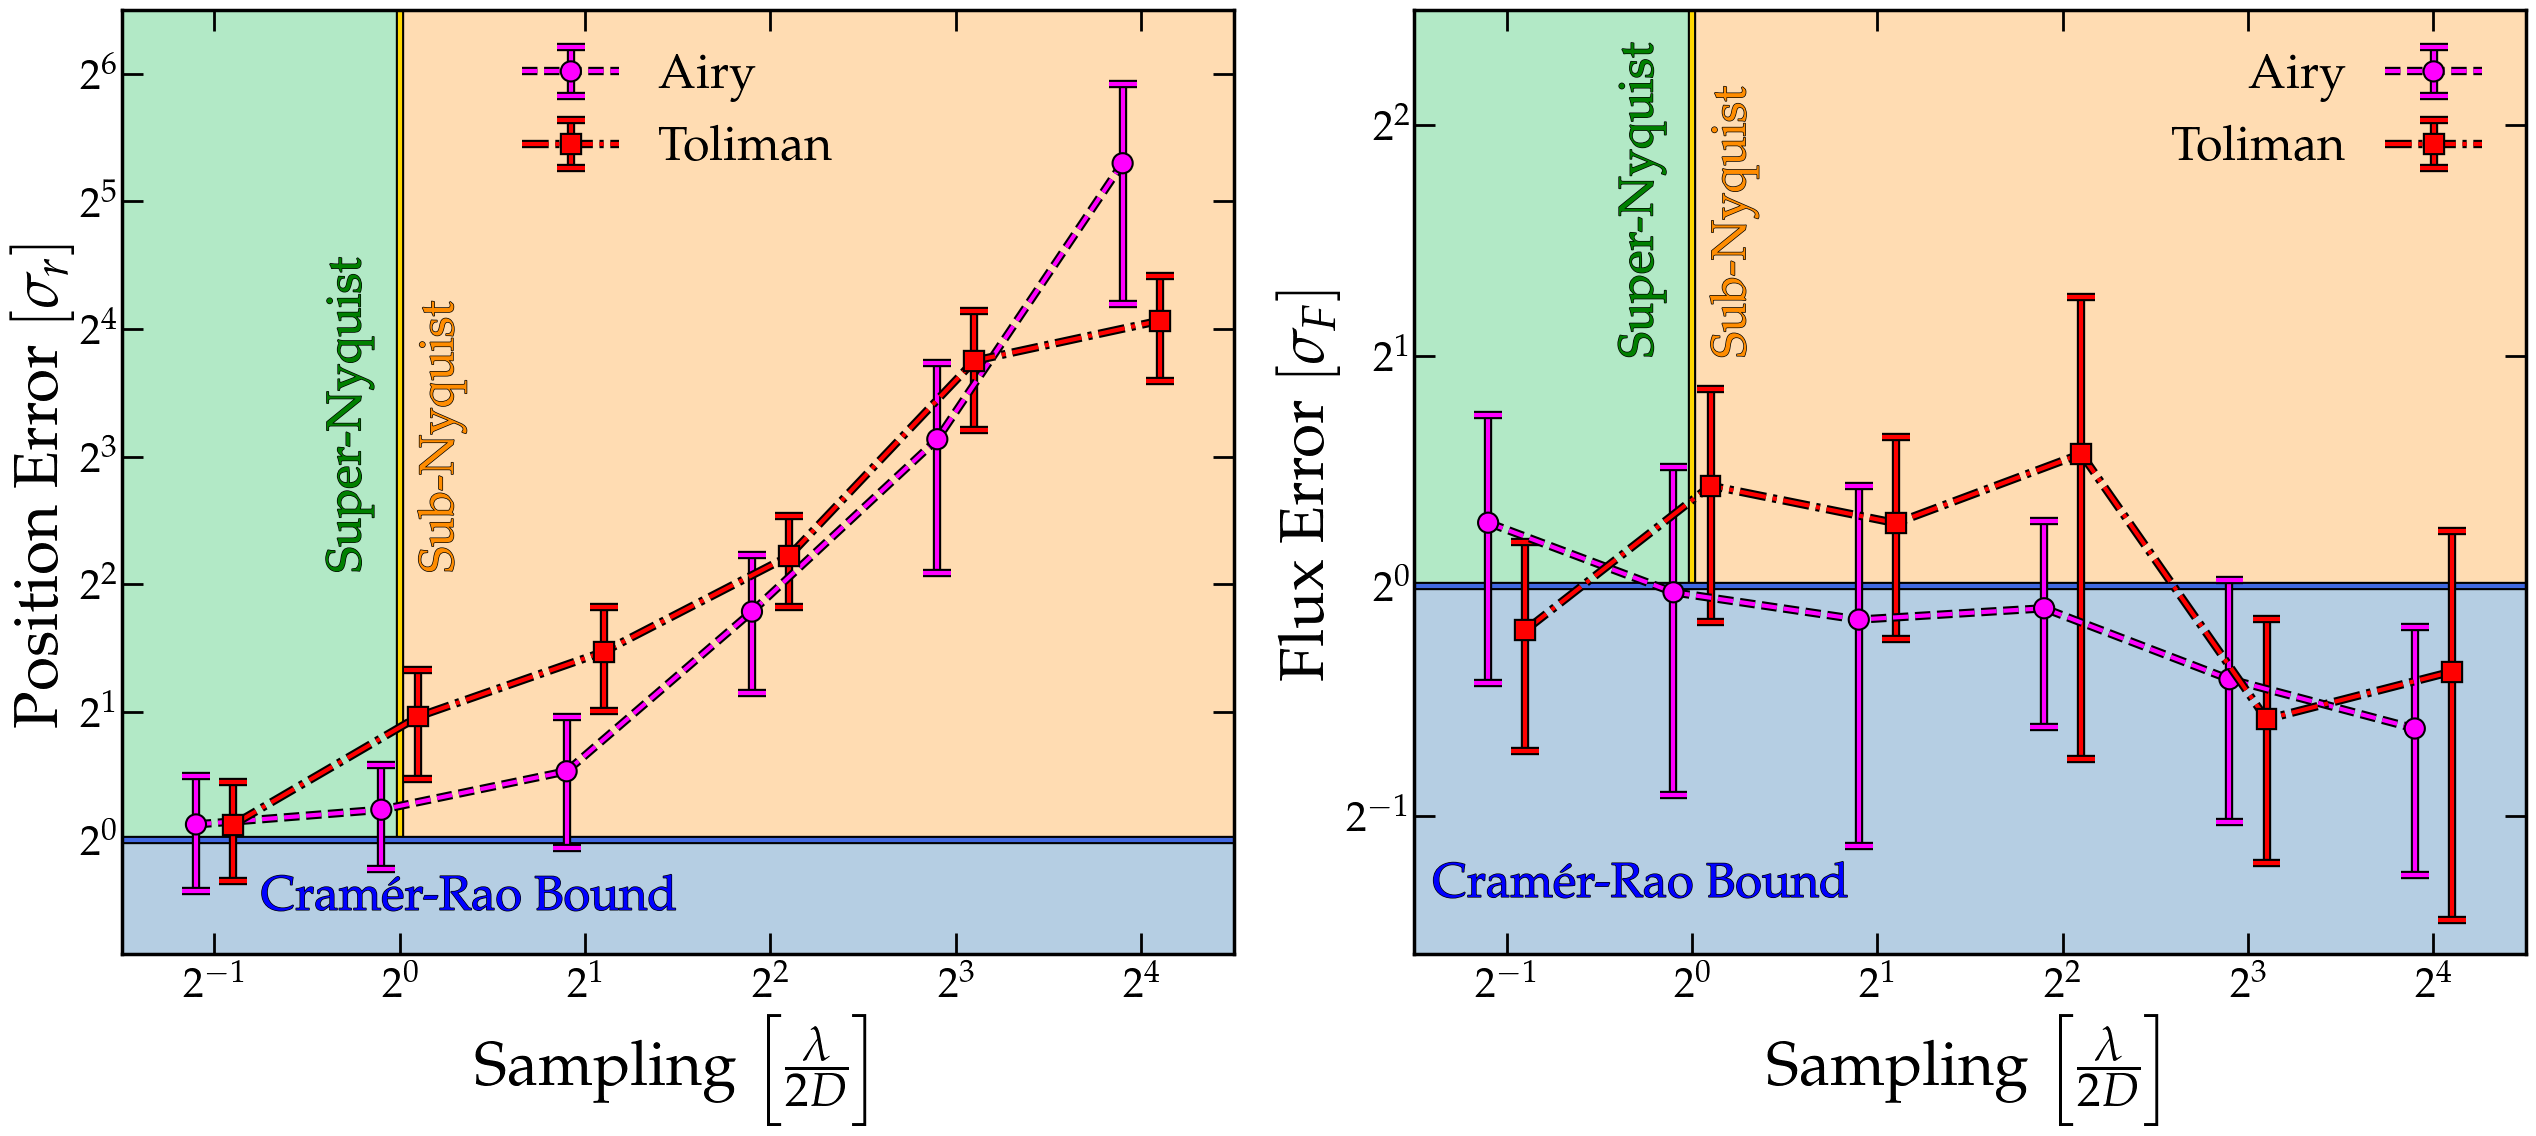

In [116]:
sampling = np.array([1/2, 1, 2, 4, 8, 16])

plt.figure(figsize=(26,12))
plt.subplot(1,2,1)
plt.axvline(1, 0.125, 1, path_effects = path_effects, color='gold')
plt.axhline(1, path_effects = path_effects, color='royalblue')

plt.fill_between(np.array([0,32]), 0, 1, alpha=0.3)
plt.fill_between(np.array([0,1]), 1, 2**7, alpha=0.3)
plt.fill_between(np.array([1,32]), 1, 2**7, alpha=0.3, color='darkorange')

plt.errorbar(sampling*(2**(-0.1)), c_rmse_pos, yerr = 2*c_stdev_pos,
             capsize=10, marker='o', ms=10, mew=3, linestyle='--', path_effects=path_effects,
             label='Airy', color='magenta')
plt.errorbar(sampling*(2**(0.1)), c_rmse_pos_tol, yerr = 2*c_stdev_pos_tol,
             capsize=10, marker='s', ms=10, mew=3, linestyle='-.', path_effects=path_effects,
             label='Toliman', color='red')

plt.text(2**(-0.75),2**(-0.55),'Cramér-Rao Bound', path_effects=text_path_effects, color='blue', fontsize=35)
plt.text(2**(-0.4),2**(2.2),'Super-Nyquist', path_effects=text_path_effects, color='green', fontsize=35,rotation=90)
plt.text(2**(0.1),2**(2.2),'Sub-Nyquist', path_effects=text_path_effects, color='darkorange', fontsize=35,rotation=90)

plt.xlabel(r'Sampling $\left[\frac{\lambda}{2 D}\right]$')
plt.ylabel(r'Position Error $\left[\sigma_r\right]$')

plt.xscale('log',base=2)
plt.yscale('log',base=2)
plt.xlim(2**(-1.5),2**(4.5))
plt.ylim(2**(-0.9),2**(6.5))
plt.legend()

plt.subplot(1,2,2)
plt.axvline(1, 0.39, 1, path_effects = path_effects, color='gold')
plt.axhline(1, path_effects = path_effects, color='royalblue')

plt.fill_between(np.array([0,32]), 0, 1, alpha=0.3)
plt.fill_between(np.array([0,1]), 1, 2**7, alpha=0.3)
plt.fill_between(np.array([1,32]), 1, 2**7, alpha=0.3, color='darkorange')

plt.errorbar(sampling*(2**(-0.1)), c_rmse_flux, yerr = 2*c_stdev_flux,
             capsize=10, marker='o', ms=10, mew=3, linestyle='--', path_effects=path_effects,
             label='Airy', color='magenta')
plt.errorbar(sampling*(2**(0.1)), c_rmse_flux_tol, yerr = 2*c_stdev_flux_tol,
             capsize=10, marker='s', ms=10, mew=3, linestyle='-.', path_effects=path_effects,
             label='Toliman', color='red')

plt.text(2**(-1.4),2**(-1.35),'Cramér-Rao Bound', path_effects=text_path_effects, color='blue', fontsize=35)
plt.text(2**(-0.4),2**(1.05),'Super-Nyquist', path_effects=text_path_effects, color='green', fontsize=35,rotation=90)
plt.text(2**(0.1),2**(1.05),'Sub-Nyquist', path_effects=text_path_effects, color='darkorange', fontsize=35,rotation=90)

plt.xlabel(r'Sampling $\left[\frac{\lambda}{2 D}\right]$')
plt.ylabel(r'Flux Error $\left[\sigma_F\right]$')

plt.xscale('log',base=2)
plt.yscale('log',base=2)
plt.xlim(2**(-1.5),2**(4.5))
plt.ylim(2**(-1.6),2**(2.5))
plt.legend(markerfirst=False)

plt.tight_layout()

plt.savefig('singlesource_nyquist_plot.pdf', transparent=False, bbox_inches='tight')
plt.savefig('singlesource_nyquist_plot.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()